# Degeneracy and robustness

In [1]:
#@title Run the following to initialize lab environment.

!pip install ipympl ipywidgets stg-net -q

import matplotlib.pyplot as plt         # import matplotlib
from matplotlib.widgets import Slider
import numpy as np                      # import numpy
import ipywidgets as widgets            # interactive display

# Colab setting for widget
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except ImportError:
    pass

# modeling library
from stg_net.neuron import LIF
from stg_net.input import Poisson_generator, Gaussian_generator, Current_injector
from stg_net.conn import Simulator
from stg_net.helper import plot_volt_trace

# setting for figures
fig_w, fig_h = 8, 6
my_fontsize = 18
my_params = {'axes.labelsize': my_fontsize,
          'axes.titlesize': my_fontsize,
          'figure.figsize': (fig_w, fig_h),
          'font.size': my_fontsize,
          'legend.fontsize': my_fontsize-4,
          'lines.markersize': 8.,
          'lines.linewidth': 2.,
          'xtick.labelsize': my_fontsize-2,
          'ytick.labelsize': my_fontsize-2}
plt.rcParams.update(my_params)
my_layout = widgets.Layout()

# Auto Reloading
%load_ext autoreload
%autoreload 2

# Widget interaction
%matplotlib widget

## Redundancy and robustness (30min)

## Constructing the pyloric circuit (30min)
In the following code we will realize the pyloric rhythm generator using our simplified neurons.

<div style="text-align: center;">
    <img src="https://github.com/weirdoglh/ComBioNetwork/blob/main/book/Lab1/pyloric-circuit.PNG?raw=true" alt="Pyloric colour" width="300"/>
    <img src="https://github.com/weirdoglh/ComBioNetwork/blob/main/book/Lab1/pyloric-colour.png?raw=true" alt="Pyloric colour" width="700"/>
</div>

(Hooper and Marder, 1987) 
(Kispersky et al., 2011) 

In the table below *columns* are **PRESYNAPTIC** neurons and *rows* are **POSTSYNAPTIC** neurons

GridspecLayout(children=(Text(value='AB', disabled=True, layout=Layout(grid_area='widget001', width='200px')),…

Output()

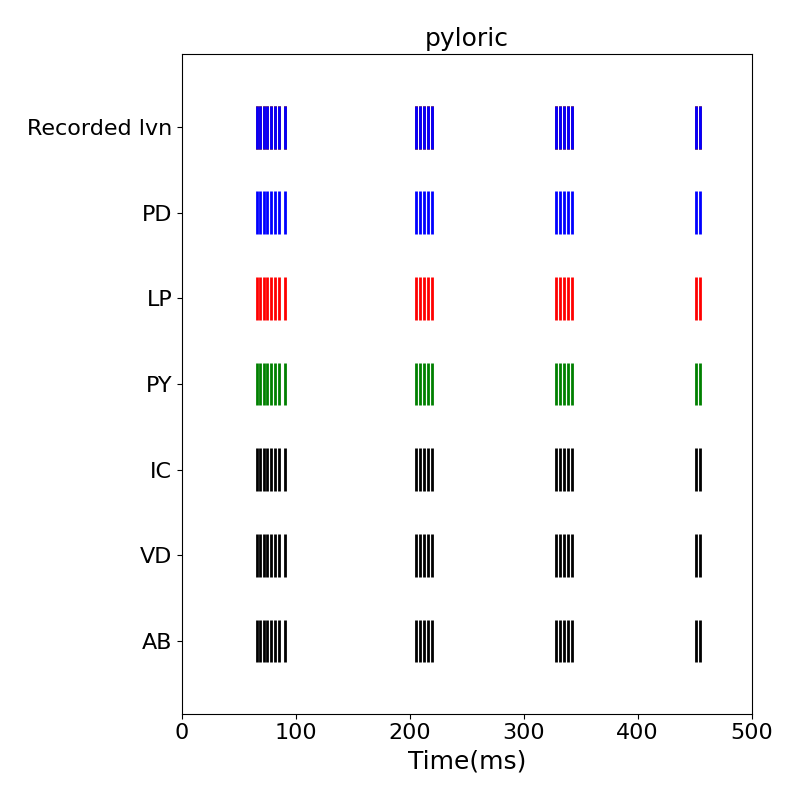

In [5]:
#@title Run the following to start pyloric circuit simulation { vertical-output: true }
# experiment setting
T, dt = 5e2, 0.1        # simulation period(ms), step size(ms)

tonic_neuron = {'tau_m':20., 'a':0., 'tau_w':30., 'b':3., 'V_reset':-55.}
adapting_neuron = {'tau_m':20., 'a':0., 'tau_w':100., 'b':0.5, 'V_reset':-55.}
initburst_neuron = {'tau_m':10., 'a':0., 'tau_w':100., 'b':1., 'V_reset':-50.}
bursting_neuron = {'tau_m':5., 'a':0., 'tau_w':100., 'b':1., 'V_reset':-46.}
irregular_neuron = {'tau_m':10., 'a':-0.01, 'tau_w':50., 'b':1.2, 'V_reset':-46.}
transient_neuron = {'tau_m':5., 'a':0.05, 'tau_w':100., 'b':0.7, 'V_reset':-60.}
delayed_neuron = {'tau_m':5., 'a':-0.1, 'tau_w':100., 'b':1., 'V_reset':-60.}

neuron_params = {'tonic_neuron': tonic_neuron, 'adapting_neuron': adapting_neuron, 
                 'initburst_neuron': initburst_neuron, 'bursting_neuron': bursting_neuron, 
                 'irregular_neuron': irregular_neuron, 'transient_neuron': transient_neuron, 
                 'delayed_neuron': delayed_neuron, 'my_neuron': tonic_neuron}

# AB-LP -0.79
# AB-PY -0.07
# VD-AB -0.04

# neurons
nrn_labels = ['AB', 'VD', 'IC', 'PD', 'LP', 'PY']
N = len(nrn_labels)
nrn_types = ['bursting_neuron']*N
rt = 50.
wts = [1.0]*N

# widget
grid = widgets.GridspecLayout(N+1, N+1)
signs = np.array([  [0 , 1 , 0 , 1 , 0 , 0],
                    [-1, 0 , -1, 0 , -1, 0],
                    [-1, -1, 0 , -1, 0 , -1],
                    [1 , 1 , 0 , 0 , -1, 0],
                    [-1, -1, 0 , -1, 0 , -1],
                    [-1, -1, 0 , -1, -1, 0]])
wsize = '200px'
for i, label in enumerate(nrn_labels):
    grid[0, i+1] = widgets.Text(value=label, disabled=True, layout=widgets.Layout(width=wsize))
for i, label in enumerate(nrn_labels):
    grid[i+1, 0] = widgets.Text(value=label, disabled=True, layout=widgets.Layout(width=wsize))
grid[0,0] = widgets.Text(value='J', disabled=True, layout=widgets.Layout(width=wsize))
for i in range(N):
    for j in range(N):
        if signs[i,j] != 0:
            grid[i+1,j+1] = widgets.FloatSlider(min=-10.0, max=-0.0, step=0.01, layout=widgets.Layout(width=wsize))
        else:
            grid[i+1,j+1] = widgets.Text(value='0', disabled=True, layout=widgets.Layout(width=wsize))

con_bars = {}
for i, tar in enumerate(nrn_labels):
    for j, src in enumerate(nrn_labels):
        con_bars['J_%s_%s'%(tar, src)] = grid[i+1,j+1]
con_pyloric = None

# updating parameters
indices = [0, 1, 2, 5, 4, 3]
nrn_ticks = [nrn_labels[i] for i in indices] + ['Recorded lvn']
def update_pyloric(**con_dict):
    # simualtor
    h = Simulator(dt=dt)

    # network of neurons
    nrns = [LIF(sim=h) for _ in range(N)]
    for nrn, label, ntype in zip(nrns, nrn_labels, nrn_types):
        nrn.name = label
        nrn.update(neuron_params[ntype])

    # background noise
    noises = [Current_injector(sim=h, rate=rt, start=int(T/dt*0.1), end=int(T/dt*0.9)) for _ in range(N)]
    for noise, nrn, wt in zip(noises, nrns, wts):
        nrn.connect(noise, {'ctype':'Static', 'weight':wt})

    # recurrent connections
    tps = [['Static']*N]*N
    con = np.reshape(np.array(list(con_dict.values()), dtype=float), (N,N))
    global con_pyloric
    con_pyloric = con_dict
    for i in range(N):
        for j in range(N):
            if signs[i][j] > 0:
                tps[i][j] = 'Gap'
            else:
                tps[i][j] = 'Static'
    dly = np.random.uniform(2., 5., (N,N))
    synspecs = [[{} for _ in range(N)] for _ in range(N)]
    for i in range(N):
        for j in range(N):
            synspecs[i][j] = {'ctype':tps[i][j], 'weight':con[i,j], 'delay':dly[i,j]}
    h.connect(nrns, nrns, synspecs)

    # simulation
    h.run(T)

    # visualization
    cs = ['k', 'k', 'k', 'b', 'g', 'purple']
    plt.clf()
    plt.title('pyloric')
    for nrn, c, l in zip(nrns, cs, indices):
        plt.eventplot(nrn.spikes['times'], lineoffsets=2*l, colors=c)
    for idx in [5, 4, 3]:
        plt.eventplot(nrns[idx].spikes['times'], lineoffsets=2*N, colors=cs[idx])
    plt.xlabel('Time(ms)')
    plt.yticks(list(np.arange(N+1)*2), nrn_ticks)
    plt.xlim([0., T])
    plt.tight_layout()

try:
  plt.figure(fig_pyloric)
  plt.clf()
except:
  print("Init figure")

fig_pyloric = plt.figure(figsize=(8,8))
widget_pyloric = widgets.interactive_output(update_pyloric, con_bars);
display(grid, widget_pyloric);

## Describe
- Find the right combination of connection weights that generate the pyloric rhythm output as recorded from the lv nerve.
- Do you need very specific parameters for this 3-stage periodic pattern to emerge?
- Try to create two different sets of parameters that give you the pyloric rhythm. Write down the connectivity matrices (in a table) and snips of the neurons’ output that you get in your plots.

## Think
- Compare your results with others'. How different are the connections? 
- In some cases, drastically changing connections doesn’t seem to affect the output. Why do you think this happens? What would be the consequences?
- Can we compare these different solutions in a qualitative or even quantitative way to determine which parameter set is better? Or in your opinion, does this difference matter or not?